YOLO NAS Training - UAV

Necessary Setup and Imports

In [ ]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to bui

RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random
import copy
import shutil

The console stream is logged into /root/sg_logs/console.log


[2024-01-05 07:18:01] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-01-05 07:18:02] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-05 07:18:02] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-01-05 07:18:17] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-05 07:18:17] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-05 07:18:17] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


Download Dataset

In [ ]:
%%capture
!pip install ultralytics
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Ql1dOvGZp8vqTAnCTntx")
project = rf.workspace("kiyong-kang-qhti3").project("plants-2l8n0")
dataset = project.version(8).download("yolov8")

Dataset Set Up

In [ ]:
# Create tip-burn segmentation directory
if not os.path.exists('./Plants-seg/train/images'):
    os.makedirs('./Plants-seg/train/images')

if not os.path.exists('./Plants-seg/train/labels'):
    os.makedirs('./Plants-seg/train/labels')

if not os.path.exists('./Plants-seg/valid/images'):
    os.makedirs('./Plants-seg/valid/images')

if not os.path.exists('./Plants-seg/valid/labels'):
    os.makedirs('./Plants-seg/valid/labels')

# Create tip-burn detection directory
if not os.path.exists('./Plants-tipburn/train/images'):
    os.makedirs('./Plants-tipburn/train/images')

if not os.path.exists('./Plants-tipburn/train/labels'):
    os.makedirs('./Plants-tipburn/train/labels')

if not os.path.exists('./Plants-tipburn/valid/images'):
    os.makedirs('./Plants-tipburn/valid/images')

if not os.path.exists('./Plants-tipburn/valid/labels'):
    os.makedirs('./Plants-tipburn/valid/labels')

In [ ]:
train_src = './Plants-8/train'
val_src = './Plants-8/valid'

train_tipburn_seg_dir = './Plants-seg/train'
val_tipburn_seg_dir = './Plants-seg/valid'

train_tipburn_det_dir = './Plants-tipburn/train'
val_tipburn_det_dir = './Plants-tipburn/valid'

In [ ]:
# Filter tipburn segmentation files
def filter_tipburn_seg(dir):
    seg_files = []
    label_files = glob.glob(dir)

    for label_file in label_files:
        filename = label_file.split('/')[-1][:-4]
        with open(label_file, 'r') as f:
            objs = f.readlines()

        for obj in objs:
            ann = obj.split()
            if len(ann) - 1 > 4:
                seg_files.append(filename)

    seg_files = list(set(seg_files))

    return seg_files

In [ ]:
# Filter tipburn object detection files
def filter_tipburn_det(dir):
    det_files = []
    label_files = glob.glob(dir)

    for label_file in label_files:
        filename = label_file.split('/')[-1][:-4]
        src = label_file.split('/')[:-2]
        src = '/'.join(src)
        with open(label_file, 'r') as f:
            objs = f.readlines()

        n_obj_tipburn = 0
        objs_tipburn = []
        objs_others = []

        for obj in objs:
            if obj[0] == '0':
                n_obj_tipburn += 1
                objs_tipburn.append(obj)
            else:
                objs_others.append(obj)

        if n_obj_tipburn == len(objs):
            filename_tipburn = filename + '.tipburn'
            label_dir_tipburn = src + '/labels/' + filename_tipburn + '.txt'
            image_dir = src + '/images/' + filename + '.jpg'
            image_dir_tipburn = src + '/images/' + filename_tipburn + '.jpg'
            det_files.append(filename_tipburn)
            os.rename(label_file, label_dir_tipburn)
            os.rename(image_dir, image_dir_tipburn)
        elif n_obj_tipburn < len(objs) and n_obj_tipburn > 0:
            filename_tipburn = filename + '.tipburn'
            label_dir_tipburn = src + '/labels/' + filename_tipburn + '.txt'
            image_dir = src + '/images/' + filename + '.jpg'
            image_dir_tipburn = src + '/images/' + filename_tipburn + '.jpg'
            det_files.append(filename_tipburn)
            shutil.copy(image_dir, image_dir_tipburn)
            with open(label_dir_tipburn, 'w') as f2:
                f2.writelines(objs_tipburn)
            with open(label_file, 'w') as f3:
                f3.writelines(objs_others)
        elif n_obj_tipburn == 0:
            continue

    return det_files

In [ ]:
# Move files
def move_files(src, dir, files):
    for filename in files:
        shutil.move(src + '/images/' + filename + '.jpg', dir + '/images/' + filename + '.jpg')
        shutil.move(src + '/labels/' + filename + '.txt', dir + '/labels/' + filename + '.txt')

In [ ]:
# Modify segmentation images/labels files only for tipburn class to remain
def modify_seg_files(dir):
    label_files = glob.glob(dir)
    for label_file in label_files:
        label_dir = copy.copy(label_file)
        img_dir = label_dir.replace('labels', 'images')
        img_dir = img_dir[:-3] + 'jpg'
        with open(label_dir, 'r') as f:
            objs = f.readlines()

        n_obj_tipburn = 0
        objs_tipburn = []
        objs_others = []

        for obj in objs:
            if obj[0] == '0':
                n_obj_tipburn += 1
                objs_tipburn.append(obj)
            else:
                objs_others.append(obj)

        if n_obj_tipburn == len(objs):
            continue
        elif n_obj_tipburn < len(objs) and n_obj_tipburn > 0:
            with open(label_dir, 'w') as f2:
                f2.writelines(objs_tipburn)
        elif n_obj_tipburn == 0:
            os.remove(img_dir)
            os.remove(label_dir)

In [ ]:
# Modify classnames in label files
def modify_labels(dir):
    label_files = glob.glob(dir)
    for label_file in label_files:
        with open(label_file, 'r') as f:
            labels = f.readlines()
        for i, label in enumerate(labels):
            if label[0] == '1':
                labels[i] = '0' + label[1:]
            elif label[0] == '2':
                labels[i] = '1' + label[1:]

        with open(label_file, 'w') as f:
            f.writelines(labels)

In [ ]:
# 1 step: create tipburn segmentation directory
seg_t_files = filter_tipburn_seg('./Plants-8/train/labels/*.txt')
seg_v_files = filter_tipburn_seg('./Plants-8/valid/labels/*.txt')

move_files(train_src, train_tipburn_seg_dir, seg_t_files)
move_files(val_src, val_tipburn_seg_dir, seg_v_files)

modify_seg_files('./Plants-seg/train/labels/*.txt')
modify_seg_files('./Plants-seg/valid/labels/*.txt')

# 2 step: create tipburn object detection directory
det_t_files = filter_tipburn_det('./Plants-8/train/labels/*.txt')
det_v_files = filter_tipburn_det('./Plants-8/valid/labels/*.txt')

move_files(train_src, train_tipburn_det_dir, det_t_files)
move_files(val_src, val_tipburn_det_dir, det_v_files)

modify_labels('./Plants-8/train/labels/*.txt')
modify_labels('./Plants-8/valid/labels/*.txt')

In [ ]:
# Add validation dataset
train_files = os.listdir(train_tipburn_det_dir + '/images')
val_files = random.sample(train_files, 34)
val_files = [val_file[:-4] for val_file in val_files]

move_files(train_tipburn_det_dir, val_tipburn_det_dir, val_files)

In [ ]:
print('./Plants-tipburn/train/images: ', len(os.listdir('./Plants-tipburn/train/images')))
print('./Plants-tipburn/valid/images: ', len(os.listdir('./Plants-tipburn/valid/images')))

./Plants-tipburn/train/images:  350
./Plants-tipburn/valid/images:  38


In [ ]:
ROOT_DIR = 'Plants-tipburn'
train_imgs_dir = 'train/images'
train_labels_dir = 'train/labels'
val_imgs_dir = 'valid/images'
val_labels_dir = 'valid/labels'
# test_imgs_dir = 'test/images'
# test_labels_dir = 'test/labels'
classes = ['Tip_Burn']

In [ ]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'classes':classes
}

In [ ]:
# Global parameters.
EPOCHS = 5
BATCH_SIZE = 16
WORKERS = 8

Visualize Ground Truth Images

In [ ]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3.5,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

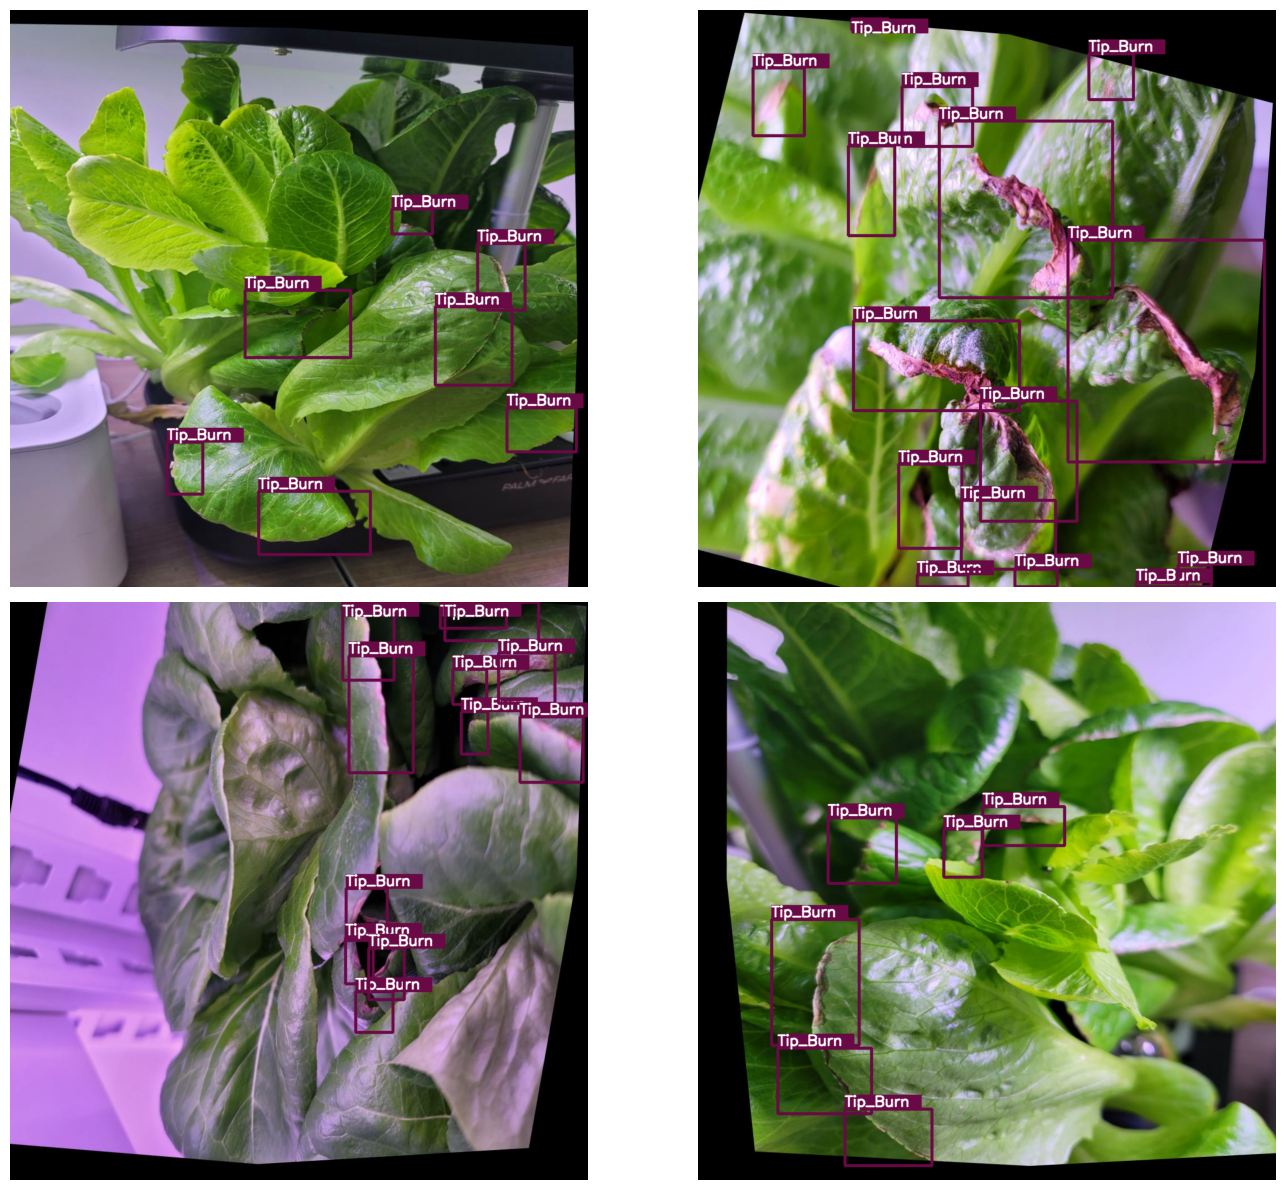

In [ ]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir),
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

Data Preparation

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2024-01-05 07:26:11] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 350/350 [00:00<00:00, 4567.51it/s]
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
[2024-01-05 07:26:11] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 38/38 [00:00<00:00, 3590.93it/s]


Transforms and Augmentation

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

In [ ]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114)

In [ ]:
# An example on how to modify augmentations
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [ ]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_empty_targets': False, 'swap': (2, 0, 1), 'input_dim': (640, 640), 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDi

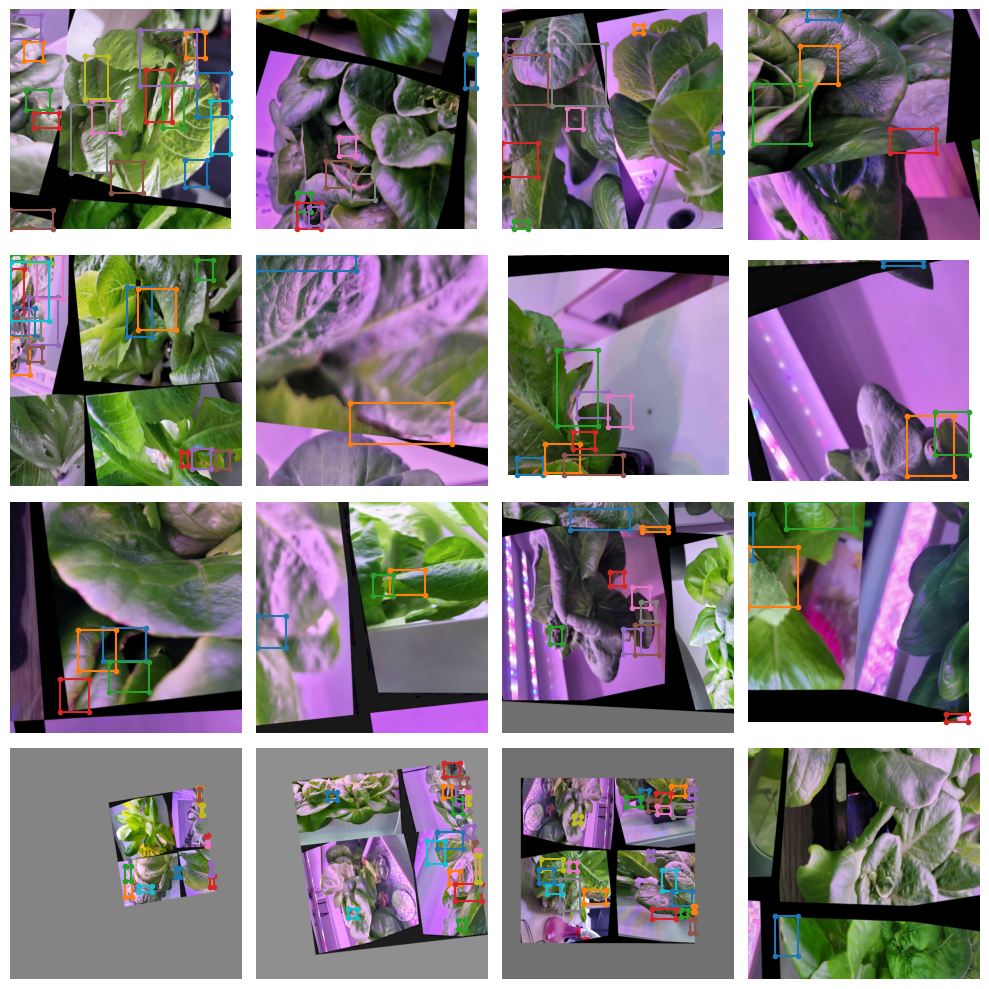

In [ ]:
# We visualize the images with augmentation here
train_data.dataset.plot(plot_transformed_data=True)

Prepare Model and Training Parameters

In [ ]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [ ]:
# yolo_nas_s, yolo_nas_m, yolo_nas_l
models_to_train = [
    'yolo_nas_l'
]

In [ ]:
CHECKPOINT_DIR = 'checkpoints'

Model Training

In [ ]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train+'_'+str(EPOCHS)+'e',
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train,
        num_classes=len(dataset_params['classes']),
        pretrained_weights="coco"
    )

    trainer.train(
        model=model,
        training_params=train_params,
        train_loader=train_data,
        valid_loader=val_data
    )

[2024-01-05 07:30:10] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:03<00:00, 68.4MB/s]
[2024-01-05 07:30:14] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
[2024-01-05 07:30:15] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240105_073015_317506`
[2024-01-05 07:30:15] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_l_5e/RUN_20240105_073015_317506
[2024-01-05 07:30:15] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_l_5e/RUN_20240105_073015_317506/console_Jan05_07_30_15.txt


Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
[2024-01-05 07:30:36] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            350       

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.4947
│   ├── Ppyoloeloss/loss_iou = 1.0978
│   ├── Ppyoloeloss/loss_dfl = 1.0165
│   └── Ppyoloeloss/loss = 3.609
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.5238
    ├── Ppyoloeloss/loss_iou = 1.0157
    ├── Ppyoloeloss/loss_dfl = 1.055
    ├── Ppyoloeloss/loss = 3.5945
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0006
    ├── F1@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50:0.95 = 0.0
    ├── Map@0.50:0.95 = 0.0001
    └── F1@0.50:0.95 = 0.0



Validating epoch 1: 100%|██████████| 3/3 [00:03<00:00,  1.14s/it]
[2024-01-05 07:32:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240105_073015_317506/ckpt_best.pth
[2024-01-05 07:32:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0033702352084219456


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.2036
│   │   ├── Epoch N-1      = 1.4947 (↘ -0.2911)
│   │   └── Best until now = 1.4947 (↘ -0.2911)
│   ├── Ppyoloeloss/loss_iou = 1.0191
│   │   ├── Epoch N-1      = 1.0978 (↘ -0.0788)
│   │   └── Best until now = 1.0978 (↘ -0.0788)
│   ├── Ppyoloeloss/loss_dfl = 0.9069
│   │   ├── Epoch N-1      = 1.0165 (↘ -0.1095)
│   │   └── Best until now = 1.0165 (↘ -0.1095)
│   └── Ppyoloeloss/loss = 3.1296
│       ├── Epoch N-1      = 3.609  (↘ -0.4794)
│       └── Best until now = 3.609  (↘ -0.4794)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2719
    │   ├── Epoch N-1      = 1.5238 (↘ -0.2519)
    │   └── Best until now = 1.5238 (↘ -0.2519)
    ├── Ppyoloeloss/loss_iou = 1.0874
    │   ├── Epoch N-1      = 1.0157 (↗ 0.0717)
    │   └── Best until now = 1.0157 (↗ 0.0717)
    ├── Ppyoloeloss/loss_dfl = 0.9691
    │   ├── Epoch N-1      = 1.055  (↘ -0.0859)
    │   └── Best until now = 1.055  (↘ -0.0859)
    ├── Ppyoloeloss/loss

Validating epoch 2: 100%|██████████| 3/3 [00:03<00:00,  1.23s/it]
[2024-01-05 07:34:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240105_073015_317506/ckpt_best.pth
[2024-01-05 07:34:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.012804570607841015


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1641
│   │   ├── Epoch N-1      = 1.2036 (↘ -0.0394)
│   │   └── Best until now = 1.2036 (↘ -0.0394)
│   ├── Ppyoloeloss/loss_iou = 0.9126
│   │   ├── Epoch N-1      = 1.0191 (↘ -0.1065)
│   │   └── Best until now = 1.0191 (↘ -0.1065)
│   ├── Ppyoloeloss/loss_dfl = 0.8425
│   │   ├── Epoch N-1      = 0.9069 (↘ -0.0644)
│   │   └── Best until now = 0.9069 (↘ -0.0644)
│   └── Ppyoloeloss/loss = 2.9192
│       ├── Epoch N-1      = 3.1296 (↘ -0.2103)
│       └── Best until now = 3.1296 (↘ -0.2103)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1868
    │   ├── Epoch N-1      = 1.2719 (↘ -0.0851)
    │   └── Best until now = 1.2719 (↘ -0.0851)
    ├── Ppyoloeloss/loss_iou = 0.9105
    │   ├── Epoch N-1      = 1.0874 (↘ -0.1769)
    │   └── Best until now = 1.0157 (↘ -0.1052)
    ├── Ppyoloeloss/loss_dfl = 0.9161
    │   ├── Epoch N-1      = 0.9691 (↘ -0.053)
    │   └── Best until now = 0.9691 (↘ -0.053)
    ├── Ppyoloeloss/loss

Validating epoch 3: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]
[2024-01-05 07:36:11] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240105_073015_317506/ckpt_best.pth
[2024-01-05 07:36:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.020550252869725227


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1324
│   │   ├── Epoch N-1      = 1.1641 (↘ -0.0317)
│   │   └── Best until now = 1.1641 (↘ -0.0317)
│   ├── Ppyoloeloss/loss_iou = 0.8533
│   │   ├── Epoch N-1      = 0.9126 (↘ -0.0593)
│   │   └── Best until now = 0.9126 (↘ -0.0593)
│   ├── Ppyoloeloss/loss_dfl = 0.7924
│   │   ├── Epoch N-1      = 0.8425 (↘ -0.0501)
│   │   └── Best until now = 0.8425 (↘ -0.0501)
│   └── Ppyoloeloss/loss = 2.7781
│       ├── Epoch N-1      = 2.9192 (↘ -0.1412)
│       └── Best until now = 2.9192 (↘ -0.1412)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.151
    │   ├── Epoch N-1      = 1.1868 (↘ -0.0358)
    │   └── Best until now = 1.1868 (↘ -0.0358)
    ├── Ppyoloeloss/loss_iou = 0.8202
    │   ├── Epoch N-1      = 0.9105 (↘ -0.0903)
    │   └── Best until now = 0.9105 (↘ -0.0903)
    ├── Ppyoloeloss/loss_dfl = 0.8861
    │   ├── Epoch N-1      = 0.9161 (↘ -0.03)
    │   └── Best until now = 0.9161 (↘ -0.03)
    ├── Ppyoloeloss/loss = 

Validating epoch 4: 100%|██████████| 3/3 [00:04<00:00,  1.55s/it]
[2024-01-05 07:37:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l_5e/RUN_20240105_073015_317506/ckpt_best.pth
[2024-01-05 07:37:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0406680703163147


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1338
│   │   ├── Epoch N-1      = 1.1324 (↗ 0.0014)
│   │   └── Best until now = 1.1324 (↗ 0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.8036
│   │   ├── Epoch N-1      = 0.8533 (↘ -0.0497)
│   │   └── Best until now = 0.8533 (↘ -0.0497)
│   ├── Ppyoloeloss/loss_dfl = 0.7578
│   │   ├── Epoch N-1      = 0.7924 (↘ -0.0346)
│   │   └── Best until now = 0.7924 (↘ -0.0346)
│   └── Ppyoloeloss/loss = 2.6952
│       ├── Epoch N-1      = 2.7781 (↘ -0.0829)
│       └── Best until now = 2.7781 (↘ -0.0829)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3099
    │   ├── Epoch N-1      = 1.151  (↗ 0.1589)
    │   └── Best until now = 1.151  (↗ 0.1589)
    ├── Ppyoloeloss/loss_iou = 0.7698
    │   ├── Epoch N-1      = 0.8202 (↘ -0.0504)
    │   └── Best until now = 0.8202 (↘ -0.0504)
    ├── Ppyoloeloss/loss_dfl = 0.8104
    │   ├── Epoch N-1      = 0.8861 (↘ -0.0757)
    │   └── Best until now = 0.8861 (↘ -0.0757)
    ├── Ppyoloeloss/loss =

[2024-01-05 07:38:27] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 5: 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


Inference

In [ ]:
os.makedirs('inference_results/images/', exist_ok=True)

Inference on Test Images

In [ ]:
ROOT_TEST = 'hit-uav/images/test/'
all_images = os.listdir(ROOT_TEST)

In [ ]:
for image in tqdm(all_images, total=len(all_images)):
    image_path = os.path.join(ROOT_TEST, image)
    out = model.predict(image_path)
    out.save('inference_results/images')
    os.rename(
        'inference_results/images/pred_0.jpg',
        os.path.join('inference_results/images/', image)
    )

  0%|          | 0/571 [00:00<?, ?it/s]

[2024-01-04 08:37:08] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/visualization/utils.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("gist_rainbow", num_classes)
[2024-01-04 08:37:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-04 08:37:09] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-01-04 08:37:10] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `f

Overlapped Ground Truth Samples

In [ ]:
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))

        class_name = classes[int(labels[box_num])]

        color = (0, 0, 255)

        cv2.rectangle(
            image,
            p1, p2,
            color=color,
            thickness=lw,
            lineType=cv2.LINE_AA
        )

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name,
            0,
            fontScale=lw / 3,
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3

        cv2.rectangle(
            image,
            (p1[0], p2[1]), new_p2,
            color=color,
            thickness=-1,
            lineType=cv2.LINE_AA
        )
        cv2.putText(
            image,
            class_name,
            (p1[0], p2[1] + h + 2 if outside else p2[1]),
            cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=lw/3,
            color=(255, 255, 255),
            thickness=tf,
            lineType=cv2.LINE_AA
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()

    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)

    num_images = len(all_training_images)

    if num_samples == -1:
        num_samples = num_images

    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.figure(figsize=(12, 9))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

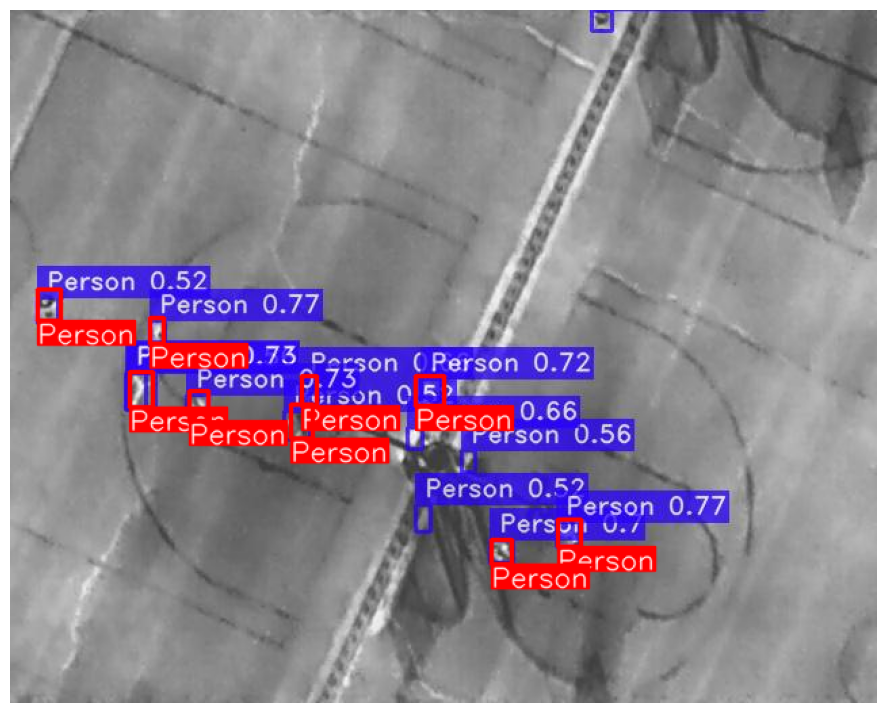

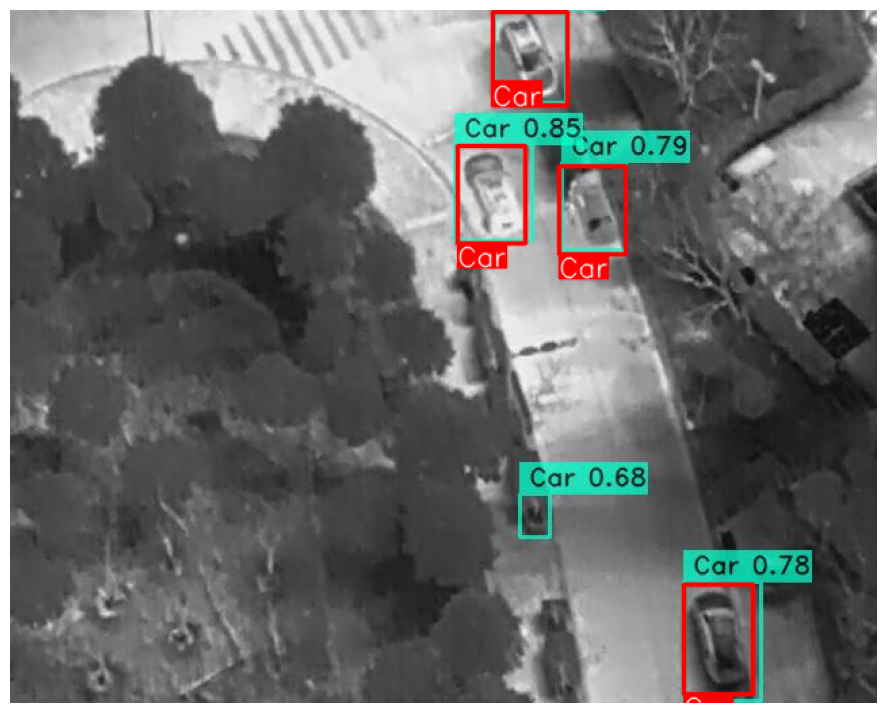

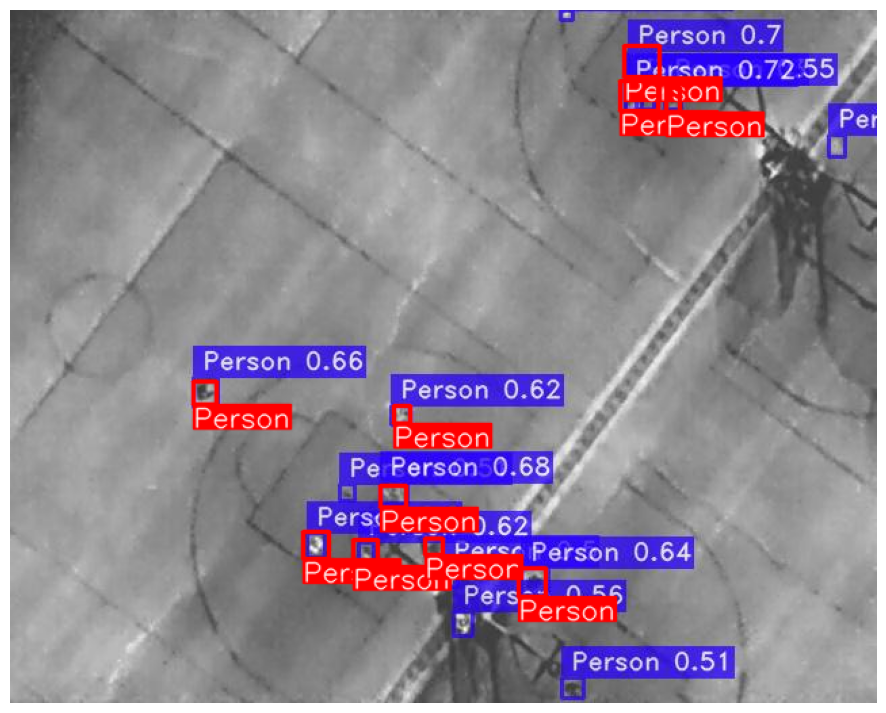

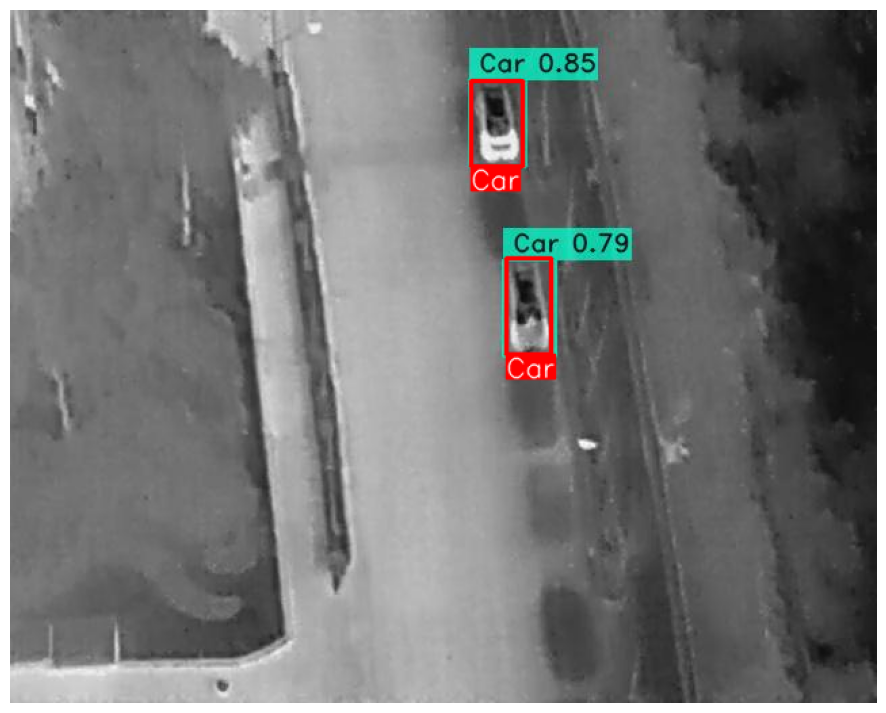

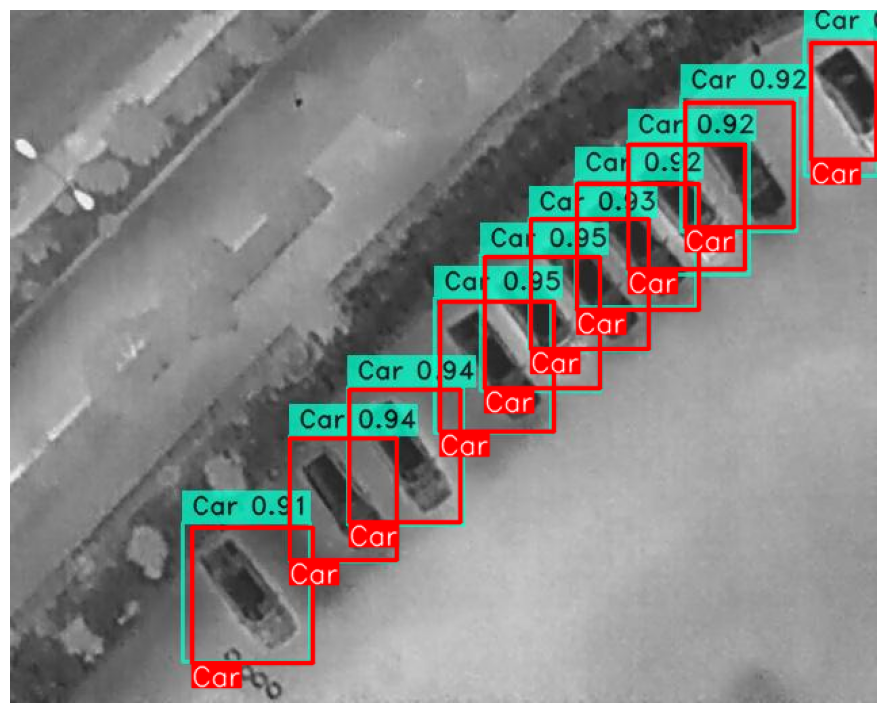

In [ ]:
# Visualize a few training images.
plot(
    image_path='inference_results/images/',
    label_path='hit-uav/labels/test/',
    num_samples=5,
)